In [ ]:
# The aim of this case study is to load the Drained cropland area data from FAO Essential Remote Se3nsing Data Product Potal, 
# and use a country country boundary (BDG in this case study) to crop the data, conduct of the drained cropland area time series 
# between 1992 and 2020, then share save the data to the users' cloud / laptop 
# Created by Pengyu Hao (pengyu.hao@fao.org) on 2026/1/20 

# User need to go through the data collections page (https://data.apps.fao.org/remote-sensing-portal/collections) of the 
# Essential Remote Sensing Data Product Portal to find the collection ID they need, 
# in this case, it is "DRAINED-AREA-CROP"

In [37]:
from pystac_client import Client
from datetime import datetime, timedelta
from urllib.parse import urlparse
import glob
import leafmap
import gcsfs
import tempfile
import fiona
import rasterio
from rasterio.mask import mask
from rasterio.enums import Resampling
from rasterio.env import Env
import matplotlib.colors as mcolors
import xml.etree.ElementTree as ET
import geopandas as gpd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
#the link to the stac in production
API_ROOT = "https://data.apps.fao.org/geospatial/search/stac"
#using client functions to see all collections available in the STAC
client = Client.open(API_ROOT)

In [4]:
#input filters for data selection
# === EDIT THESE ===
# You can put: []  or ""  or None  to search without a collection filter.
# Or provide one or many collection ids, e.g. ["L1-UTM-NPP-D"] or "L1-UTM-NPP-D"
COLLECTIONS = "DRAINED-AREA-CROP"   # or [] or None
# Bounding box in WGS84 [minx, miny, maxx, maxy]; set to None to ignore
BBOX =[87, 20, 93, 27]   # or None
# Time range; set to None to ignore (STAC interval string "start/end")
#print(starttime_str)
DATETIME = "1992-01-01/2022-12-31"  # or None
# Optional: LIKE pattern for item id (SQL wildcards: % = any string, _ = single char)
# Example: "%60W.2024-12-D3%"  |  set to None to skip LIKE filtering
ITEM_ID_LIKE = None
# Optional extra STAC 'query' filter
QUERY = {
    # "eo:cloud_cover": {"lt": 20}
}
# Optional cap on results
LIMIT = 100
print("STAC_API:", API_ROOT)
print("COLLECTIONS:", COLLECTIONS)
print("BBOX:", BBOX)
print("DATETIME:", DATETIME)
print("ITEM_ID_LIKE:", ITEM_ID_LIKE)

STAC_API: https://data.apps.fao.org/geospatial/search/stac
COLLECTIONS: DRAINED-AREA-CROP
BBOX: [87, 20, 93, 27]
DATETIME: 1992-01-01/2022-12-31
ITEM_ID_LIKE: None


In [5]:
#functions to select items from collection
def _normalize_collections(val):
    if val is None:
        return None
    if isinstance(val, str):
        val = val.strip()
        return [val] if val else None
    if isinstance(val, (list, tuple)):
        vals = [v for v in (x.strip() for x in val) if v]
        return vals or None
    return None

search_kwargs = dict(
    collections=_normalize_collections(COLLECTIONS),
    bbox=BBOX or None,
    datetime=DATETIME or None,
    query=QUERY or None,
    limit=LIMIT,
)

#get and show the list of the selected items of the recent 15 day.
# Add LIKE filter only if user provided ITEM_ID_LIKE
if ITEM_ID_LIKE:
    search_kwargs.update({
        "filter_lang": "cql2-json",
        "filter": {
            "op": "like",
            "args": [
                {"property": "id"},
                ITEM_ID_LIKE
            ]
        }
    })

search = client.search(**search_kwargs)
items = list(search.get_items())
for item in items:
    print(item.id)
#print(len(items))

FAOSTAT.DRAINED-AREA-CROP.2022
FAOSTAT.DRAINED-AREA-CROP.2021
FAOSTAT.DRAINED-AREA-CROP.2020
FAOSTAT.DRAINED-AREA-CROP.2019
FAOSTAT.DRAINED-AREA-CROP.2018
FAOSTAT.DRAINED-AREA-CROP.2017
FAOSTAT.DRAINED-AREA-CROP.2016
FAOSTAT.DRAINED-AREA-CROP.2015
FAOSTAT.DRAINED-AREA-CROP.2014
FAOSTAT.DRAINED-AREA-CROP.2013
FAOSTAT.DRAINED-AREA-CROP.2012
FAOSTAT.DRAINED-AREA-CROP.2011
FAOSTAT.DRAINED-AREA-CROP.2010
FAOSTAT.DRAINED-AREA-CROP.2009
FAOSTAT.DRAINED-AREA-CROP.2008
FAOSTAT.DRAINED-AREA-CROP.2007
FAOSTAT.DRAINED-AREA-CROP.2006
FAOSTAT.DRAINED-AREA-CROP.2005
FAOSTAT.DRAINED-AREA-CROP.2004
FAOSTAT.DRAINED-AREA-CROP.2003
FAOSTAT.DRAINED-AREA-CROP.2002
FAOSTAT.DRAINED-AREA-CROP.2001
FAOSTAT.DRAINED-AREA-CROP.2000
FAOSTAT.DRAINED-AREA-CROP.1999
FAOSTAT.DRAINED-AREA-CROP.1998
FAOSTAT.DRAINED-AREA-CROP.1997
FAOSTAT.DRAINED-AREA-CROP.1996
FAOSTAT.DRAINED-AREA-CROP.1995
FAOSTAT.DRAINED-AREA-CROP.1994
FAOSTAT.DRAINED-AREA-CROP.1993
FAOSTAT.DRAINED-AREA-CROP.1992


In [19]:
# download selected items
PREVIEW_SCALE = 16                 # 8 = sharper, 16 = faster, 32 = fastest
DOWNLOAD_CHUNK = 8 * 1024 * 1024   # 8MB streaming chunks
def _is_geotiff(a):
    mt = (a.media_type or "").lower()
    href = (a.href or "").lower()
    return ("image/tiff" in mt) or href.endswith((".tif", ".tiff"))

# pick asset
def pick_asset(it):
    preferred = ("data", "visual", "rendered_preview", "B04", "B03", "B02", "nir")
    for k in preferred:
        if k in it.assets and _is_geotiff(it.assets[k]):
            return it.assets[k], k
    for k, a in it.assets.items():
        if _is_geotiff(a):
            return a, k
    return None, None
    
# function to normalize the gs path
def normalize_to_gs(href: str) -> str:
    if not href:
        return href
    if href.startswith("gs://"):
        return href

    if "storage.cloud.google.com" in href:
        p = urlparse(href)
        path = p.path.lstrip("/")  # bucket/object
        return f"gs://{path}"

    if "storage.googleapis.com" in href:
        p = urlparse(href)
        parts = p.path.lstrip("/").split("/", 1)
        if len(parts) == 2:
            bucket, obj = parts
            return f"gs://{bucket}/{obj}"
    return href
#function to download data to compute engine
def download_gcs_to_temp(gs_uri: str, local_path) -> str:
    if not gs_uri.startswith("gs://"):
        return gs_uri
    fs = gcsfs.GCSFileSystem()
    bucket_and_key = gs_uri[5:]
    #tmp = tempfile.NamedTemporaryFile(suffix=".tif", delete=False)
    #local_path = tmp.name
    #local_path = "/RSP_test/ASIS_test/GS1LCC/Global/"+"x.tif"
    print(f"Downloading (streamed) {gs_uri}")
    with fs.open(bucket_and_key, "rb") as src, open(local_path, "wb") as dst:
        while True:
            chunk = src.read(DOWNLOAD_CHUNK)
            if not chunk:
                break
            dst.write(chunk)
    return local_path

#download script
#local path base
Path_base = "/home/pengyu_hao_fao_org/"
Path_folder = "RSP_test/GHG-test/DrainedCropArea/raw/"
#print(item.id)
for item in items:
    Path_local = Path_base + Path_folder + item.id + ".tif"
    asset, asset_key = pick_asset(item)
    if not asset:
        raise RuntimeError(f"No GeoTIFF/COG asset found for item {item.id}")
    href = asset.href or asset.get_absolute_href()
    if not href:
        raise RuntimeError(f"Asset '{asset_key}' has no usable href.")
    print(href)
    gs_uri = normalize_to_gs(href)
    #download the item to Path_local
    download_gcs_to_temp(gs_uri, Path_local)
    print(Path_local)

https://storage.googleapis.com/fao-gismgr-faostat-data/DATA/FAOSTAT/MAPSET/DRAINED-AREA-CROP/FAOSTAT.DRAINED-AREA-CROP.2022.tif
/home/pengyu_hao_fao_org/RSP_test/GHG-test/DrainedCropArea/raw/FAOSTAT.DRAINED-AREA-CROP.2022.tif
https://storage.googleapis.com/fao-gismgr-faostat-data/DATA/FAOSTAT/MAPSET/DRAINED-AREA-CROP/FAOSTAT.DRAINED-AREA-CROP.2021.tif
/home/pengyu_hao_fao_org/RSP_test/GHG-test/DrainedCropArea/raw/FAOSTAT.DRAINED-AREA-CROP.2021.tif
https://storage.googleapis.com/fao-gismgr-faostat-data/DATA/FAOSTAT/MAPSET/DRAINED-AREA-CROP/FAOSTAT.DRAINED-AREA-CROP.2020.tif
/home/pengyu_hao_fao_org/RSP_test/GHG-test/DrainedCropArea/raw/FAOSTAT.DRAINED-AREA-CROP.2020.tif
https://storage.googleapis.com/fao-gismgr-faostat-data/DATA/FAOSTAT/MAPSET/DRAINED-AREA-CROP/FAOSTAT.DRAINED-AREA-CROP.2019.tif
/home/pengyu_hao_fao_org/RSP_test/GHG-test/DrainedCropArea/raw/FAOSTAT.DRAINED-AREA-CROP.2019.tif
https://storage.googleapis.com/fao-gismgr-faostat-data/DATA/FAOSTAT/MAPSET/DRAINED-AREA-CROP/FAO

In [28]:
# using BGD boundary to clip all download images
Out_folder = "RSP_test/GHG-test/DrainedCropArea/BGD/"
# get the geom for the BGD
shp_file = "/home/pengyu_hao_fao_org/Boundary/Global/shp/Global.shp"
shp = fiona.open(shp_file)
#print(shp)
# The attribute and value you are looking for
attribute_name = 'ISO3CD'
attribute_value = 'BGD'

# Open the shapefile, and get the geometry of the selected feature
# with fiona.open(shapefile_path) as shapefile:
for feature in shp:
    # Check if the attribute matches the desired value
    if feature['properties'][attribute_name] == attribute_value:
        geom = feature['geometry']
        break
# Open the shapefile, and get the geometry of the selected feature
# with fiona.open(shapefile_path) as shapefile:
for feature in shp:
    # Check if the attribute matches the desired value
    if feature['properties'][attribute_name] == attribute_value:
        geom = feature['geometry']
        break
print(geom)

# for each reaster, clip it with the BGD boundary
rasters = glob.glob(Path_base + Path_folder + "*.tif")
rasters.sort()
for raster in rasters:
    print(raster)
    index_start = raster.rfind("/")
    index_end = raster.find(".tif")
    temp_name = raster[index_start + 1 :index_end]
    output_raster_path = Path_base + Out_folder + temp_name + ".BDG.tif"
    raster_tmp = rasterio.open(raster)
    out_tmp_image, out_transform = mask(raster_tmp,[geom],crop=True)
    # Update the metadata of the output raster
    out_meta = raster_tmp.meta.copy()
    out_meta.update({
        'height': out_tmp_image.shape[1],
        'width': out_tmp_image.shape[2],
        'transform': out_transform
    })
    # export the selected image to folder
    with rasterio.open(output_raster_path, 'w', **out_meta) as dest:
        dest.write(out_tmp_image)
    #print(out_ASIS_tmp_image)
    print("data saved at: " + output_raster_path)

fiona.Geometry(coordinates=[[[(88.41675799200004, 26.612913999000057), ...]], ...], type='MultiPolygon')
/home/pengyu_hao_fao_org/RSP_test/GHG-test/DrainedCropArea/raw/FAOSTAT.DRAINED-AREA-CROP.1992.tif
data saved at: /home/pengyu_hao_fao_org/RSP_test/GHG-test/DrainedCropArea/BGD/FAOSTAT.DRAINED-AREA-CROP.1992.BDG.tif
/home/pengyu_hao_fao_org/RSP_test/GHG-test/DrainedCropArea/raw/FAOSTAT.DRAINED-AREA-CROP.1993.tif
data saved at: /home/pengyu_hao_fao_org/RSP_test/GHG-test/DrainedCropArea/BGD/FAOSTAT.DRAINED-AREA-CROP.1993.BDG.tif
/home/pengyu_hao_fao_org/RSP_test/GHG-test/DrainedCropArea/raw/FAOSTAT.DRAINED-AREA-CROP.1994.tif
data saved at: /home/pengyu_hao_fao_org/RSP_test/GHG-test/DrainedCropArea/BGD/FAOSTAT.DRAINED-AREA-CROP.1994.BDG.tif
/home/pengyu_hao_fao_org/RSP_test/GHG-test/DrainedCropArea/raw/FAOSTAT.DRAINED-AREA-CROP.1995.tif
data saved at: /home/pengyu_hao_fao_org/RSP_test/GHG-test/DrainedCropArea/BGD/FAOSTAT.DRAINED-AREA-CROP.1995.BDG.tif
/home/pengyu_hao_fao_org/RSP_test/G

/home/pengyu_hao_fao_org/RSP_test/GHG-test/DrainedCropArea/BGD/FAOSTAT.DRAINED-AREA-CROP.1992.BDG.tif
/home/pengyu_hao_fao_org/RSP_test/GHG-test/DrainedCropArea/BGD/FAOSTAT.DRAINED-AREA-CROP.1993.BDG.tif
/home/pengyu_hao_fao_org/RSP_test/GHG-test/DrainedCropArea/BGD/FAOSTAT.DRAINED-AREA-CROP.1994.BDG.tif
/home/pengyu_hao_fao_org/RSP_test/GHG-test/DrainedCropArea/BGD/FAOSTAT.DRAINED-AREA-CROP.1995.BDG.tif
/home/pengyu_hao_fao_org/RSP_test/GHG-test/DrainedCropArea/BGD/FAOSTAT.DRAINED-AREA-CROP.1996.BDG.tif
/home/pengyu_hao_fao_org/RSP_test/GHG-test/DrainedCropArea/BGD/FAOSTAT.DRAINED-AREA-CROP.1997.BDG.tif
/home/pengyu_hao_fao_org/RSP_test/GHG-test/DrainedCropArea/BGD/FAOSTAT.DRAINED-AREA-CROP.1998.BDG.tif
/home/pengyu_hao_fao_org/RSP_test/GHG-test/DrainedCropArea/BGD/FAOSTAT.DRAINED-AREA-CROP.1999.BDG.tif
/home/pengyu_hao_fao_org/RSP_test/GHG-test/DrainedCropArea/BGD/FAOSTAT.DRAINED-AREA-CROP.2000.BDG.tif
/home/pengyu_hao_fao_org/RSP_test/GHG-test/DrainedCropArea/BGD/FAOSTAT.DRAINED-ARE

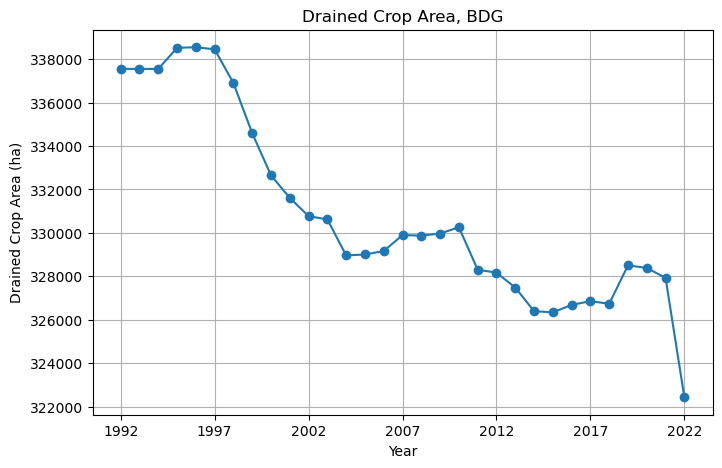

In [42]:
# for each reaster, calculate the drained crop area sum and draw a line graph
Fig_folder = "RSP_test/GHG-test/DrainedCropArea/Fig/"
BGD_rasters = glob.glob(Path_base + Out_folder + "*.tif")
BGD_rasters.sort()
#print(BGD_rasters)
df = pd.DataFrame({
    "Year": [],
    "Drained Crop Area (ha)": []
})
#print(len(df))
for cog_path in BGD_rasters:
    print(cog_path)
    year_index = cog_path.find("BDG")
    year = cog_path[year_index-5:year_index-1]
    #print(year)
    with rasterio.open(cog_path) as dataset:
        # Read the first (and only) band
        band = dataset.read(1, masked=True)  # masked handles nodata values safely
        # Calculate the sum, ignoring nodata
        total_sum = band.sum()
        total_sum = round(float(total_sum), 2)
        #add a line to the df
        df.loc[len(df)] = [year, total_sum]
print(df)
plt.figure(figsize=(8, 5))
plt.plot(
    df["Year"],
    df["Drained Crop Area (ha)"],
    marker="o",
    linestyle="-"
)
plt.xticks(df["Year"][::5])
plt.xlabel("Year")
plt.ylabel("Drained Crop Area (ha)")
plt.title("Drained Crop Area, BDG")
plt.grid(True)
#save the graph to fig path
output_path = Path_base+Fig_folder+"Drained_crop_area.BDG.png"
plt.savefig(output_path, dpi=300, bbox_inches="tight")
#plt.close()